<a href="https://colab.research.google.com/github/myrronaguila/analyze_sqc/blob/main/Plots/RN_and_EJ_of_Transmons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Relation between EJ, and RN of Transmon Junctions
By Myrron Albert Callera Aguila, PhD (first updated 20231013)

In [ ]:
!pip install lmfit==1.2.2

In [ ]:
# Imported libraries
import numpy as np #numpy 1.25
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import inspect #useful for printing python modules uploaded
import sys #for printing imported python modules and versions
import mpmath as mp
import lmfit as lm
import scipy as sp

In [ ]:
#for KDE
from scipy import stats
from sklearn.neighbors import KernelDensity
from lmfit.models import GaussianModel
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm
from uncertainties import ufloat
from uncertainties import ufloat
from lmfit import Model, Parameters
from lmfit.models import QuadraticModel
from scipy.stats import linregress #obtain get guess functions

###Disclaimer:

For users of this notebook who find the contents here useful for their ongoing work, please cite or acknowledge my contribution to your work, no matter how small it is. This means a lot. Ideas put in this package took months or even years of expertise to implement.

## Code for Optimizing Kernel Density Estimation using Scikit Learn

Create optimizer for Empirical Probability Density Distribution Function based on Ref. [1].

In [ ]:
#Create optimizer for empirical probability density distribution
def optimize_kde_pdf(xdata, ydata, bwid_lst, show='Y'):
  """
  Optimize Kernel Density Distribution of Stochastic Data
  Input:
    xdata : 1D numpy array
      interpolating data
    ydata: 1D numpy array
      y-data values to be trained
    kde_bwidth_lst : list of values
      kde_bwid_lst[0] : starting bandwidth based on sample data
      kde_bwid_lst[1] : ending bandwidth based on sample data
      kde_bwid_lst[2] : step bwidth based on sample data
  return:
    y_pdf_opt: 1D numpy array
      Optimized Probability Density Function
    y_cdf_opt: 1D numpy array
      Corresponding Data Functional Distribution
  """
  # prepare necessary arrays for kde analysis
  xdata_interp = xdata[:, np.newaxis]
  ydata_train = ydata[:, np.newaxis]
  h_vals = np.arange(bwid_lst[0], bwid_lst[1], bwid_lst[2])
  kernels = ['cosine', 'epanechnikov', 'exponential', 'gaussian',
             'linear', 'tophat']

  #prepare scoring for kernels (data filters at certain bandwidths)
  def my_scores(estimator, X):
    """
    Giving scores to a filter function
    Input :
      estimator : string
        Kernels
      X : 1d numpy array
        float
    """
    scores = estimator.score_samples(X)
    # Remove -inf
    scores = scores[scores != float('-inf')]
    # Return the mean values
    return np.mean(scores)

  #Perform Gridsearch for KDE
  grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': h_vals, 'kernel': kernels},
                    scoring=my_scores)
  grid.fit(ydata_train)
  best_kde = grid.best_estimator_
  log_dens = best_kde.score_samples(xdata_interp) #log max likelihood ratio

  #show report for fit
  if show == 'Y':
    print("Best Kernel: " + best_kde.kernel+" h="+"{:.2f}".format(best_kde.bandwidth))

  #Calculate for Probability Density estimation
  y_pdf_opt = np.exp(log_dens)  #maximum likelihood expressed in PDF

  #obtain numerical cumulative distribution function from KDE
  y_cdf_opt = np.cumsum(y_pdf_opt)
  y_cdf_opt = y_cdf_opt / np.max(y_cdf_opt)
  return y_pdf_opt

def npdf_to_cdf(y_pdf):
  """Convert numerical pdf to cdf"""
  #obtain numerical cumulative distribution function from KDE
  y_cdf_opt = np.cumsum(y_pdf)
  y_cdf_opt = y_cdf_opt / np.max(y_cdf_opt)
  return y_cdf_opt

def Gaussian(x, mu, sigma, Amp):
  # Set an adjustable gaussian distribution
  # for a normalized Gaussian Distribution, Amp=1
  A = 1/(sigma*np.sqrt(2*np.pi))
  B = np.exp(-(x-mu)**2/(2*(sigma**2)))
  return Amp*A*B

def lm_gauss_fit(xdata, ydata, show=['N','N']):
  """
  Gaussian fit from PDF to obtain a statistic using LMFIT library
  Input :
    xdata : 1D numpy array
      x-data fit
    ydata : 1D numpy array
      y-data fit
    show : list of strings
      show[0] = 'Y' - show fit report
      show[1] = 'Y' - show fitting
  """
  mod = GaussianModel()
  pars = mod.guess(ydata, x=xdata)
  init = mod.eval(pars, x=xdata)
  out = mod.fit(ydata, pars, x=xdata)
  if show[0] == 'Y':
    print(out.fit_report(min_correl=0.25))
  if show[1] == 'Y':
    #show amplitude fit
    wfig = 8.6
    fig = plt.figure(constrained_layout=True, figsize=(cm_to_inch(wfig),
                                                       cm_to_inch(wfig)))
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig, hspace =0.05, wspace=0.1)
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.plot(xdata, ydata)
    ax1.plot(xdata, init, '--', label='initial fit')
    ax1.plot(xdata, out.best_fit, '-', label='best fit')
    ax1.set_xlabel('Parameters')
    ax1.set_ylabel('PDF')
    ax1.legend()

  """--Retrieve extracted data from fitting function-------"""
  name = ['amplitude', 'center', 'sigma','fwhm', 'height']
  # strange dictionary
  out_dict_val_stderr = {name[i]: [out.params[name[i]].value,
                                  out.params[name[i]].stderr] for i in range(len(name))}
  return out.best_fit, out_dict_val_stderr

def ecdf(a):
  #ecdf depending on array of data
  #https://stackoverflow.com/questions/24788200/calculate-the-cumulative-distribution-function-cdf-in-python
    # a represents set of data obtained from the distribution over long time spans
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / np.amax(cusum)

def plot_ecdf(a):
  #convert ecdf to x,y cdf for step-post
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    #plt.plot(x, y, drawstyle='steps-post')
    return x,y

#plotting events
def cm_to_inch(x):
  # change font size to 9.0 for publication quality figures
  return x/2.54

# Creating Resistance Variations

In [59]:
# set dummy variables
counts = 32*4 #number of samples
samples_arr = np.linspace(1, counts, counts) #in samples
mu, sigma = 13, 0.6 #mean, standard deviation and Amplitude of Gaussian distrubution

R1_arr = np.random.normal(loc=mu, scale=sigma, size=counts) # spread of T1 in us.
#error of fit must be uniform if given the same parameters to resolve T1 from time domain
R1_xval = np.linspace(np.amin(R1_arr), np.amax(R1_arr), counts) #synthetic distribution value x

Best Kernel: tophat h=0.45
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 128
    # variables        = 3
    chi-square         = 0.06272306
    reduced chi-square = 5.0178e-04
    Akaike info crit   = -969.495223
    Bayesian info crit = -960.939132
    R-squared          = 0.98694393
[[Variables]]
    amplitude:  1.01505343 +/- 0.00714210 (0.70%) (init = 1.511844)
    center:     13.0069736 +/- 0.00565673 (0.04%) (init = 13.0027)
    sigma:      0.70124787 +/- 0.00577609 (0.82%) (init = 0.8796181)
    fwhm:       1.65131250 +/- 0.01360166 (0.82%) == '2.3548200*sigma'
    height:     0.57746735 +/- 0.00404209 (0.70%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, sigma) = +0.5897


Resistance Yield
CV_Rj1=5.4+/-0.0 %


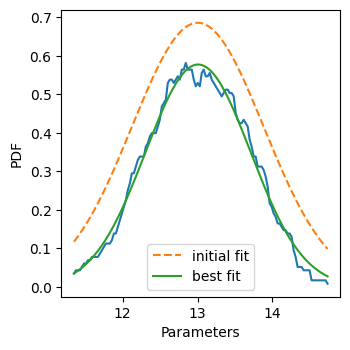

In [60]:
# Perform fit
# obtain pdf and CDF via kde
R1_pdf_kde = optimize_kde_pdf(xdata=R1_xval, ydata=R1_arr, bwid_lst=[0.3, 0.5, 0.05], show='Y')
R1_cdf_kde = npdf_to_cdf(R1_pdf_kde)

#Gaussian Fit for PDF
R1_pdf_fit, R1_fit_params = lm_gauss_fit(xdata=R1_xval, ydata=R1_pdf_kde, show=['Y','Y'])
R1_cdf_fit = npdf_to_cdf(R1_pdf_fit)

# get experimental CDF
R1_x, R1_ecdf = ecdf(R1_arr) # can be plotted in X-axis

# get resistance variations
R1_std = ufloat(R1_fit_params['sigma'][0], R1_fit_params['sigma'][1])
R1_mean = ufloat(R1_fit_params['center'][0], R1_fit_params['center'][1])
CV_Rj1 = (R1_std/R1_mean)
print('\n')
print('Resistance Yield')
print('CV_Rj1={:.1f}+/-{:.1f} %'.format(CV_Rj1.n*100, CV_Rj1.std_dev*100))

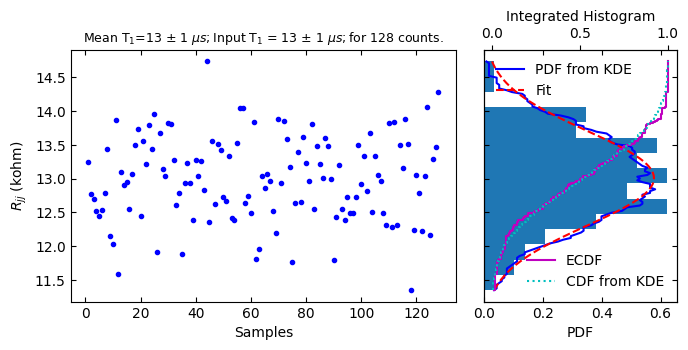

In [61]:
wfig = 8.6
fig = plt.figure(constrained_layout=True, figsize=(2*cm_to_inch(wfig),
                                                   1*cm_to_inch(wfig)))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, hspace =0.05, wspace=0.05,
                         width_ratios=(2, 1))
ax1 = fig.add_subplot(spec[0, 0]) #scatter errorbar plot
ax2 = fig.add_subplot(spec[0, 1], sharey=ax1) #histogram
ax2t = ax2.twiny()

#scatter error bar plot
title = r'Mean T$_{1}$=' +str(round(R1_fit_params['center'][0])) +' $\pm$ ' + str(round(R1_fit_params['sigma'][0])) + ' $\mu s; $'
title1 = r'Input T$_{1}$ = ' + str(round(mu))  + ' $\pm$ ' + str(round(sigma)) + ' $\mu s; $'
title2 = r'for '+str(counts) +' counts.'
ax1.set_title(title + title1 + title2, fontsize=9)
ax1.plot(samples_arr, R1_arr, 'b.')
#ax1.set_ylim(40, 160)
ax1.set_xlabel('Samples')
ax1.set_ylabel(r'$R_{jj}$ (kohm)')
ax1.tick_params(axis='both', which='both', direction='in', top=True, bottom=True)

#draw pdf from kde, y-axis values, x-axis = pdf
#draw bins and fitting
ax2.hist(R1_arr, bins=15, orientation='horizontal', density=True) #experiment with bins
ax2.plot(R1_pdf_kde,R1_xval, 'b-', label='PDF from KDE') #experiment
ax2.plot(R1_pdf_fit,R1_xval, 'r--', label='Fit') #experiment
ax2.tick_params(axis="y", labelleft=False)
ax2.set_xlabel('PDF')
#ax2.set_xlim(0, 0.02)
ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax2.legend(loc='upper left', frameon=False)

#draw cdf from kde
ax2t.plot(R1_ecdf, R1_x, 'm-', drawstyle='steps-post', label='ECDF')
ax2t.plot(R1_cdf_kde, R1_xval, 'c:', drawstyle='steps-post', label='CDF from KDE')
ax2t.set_xlabel('Integrated Histogram')
ax2t.legend(loc='lower right', frameon=False)

#plt.savefig('R1_vs_samples.png', dpi=300)
plt.show()

#Definition of Transmon Frequency and Key Variations:

We start first with the definition of the charging energy and inductive energies of a quantum circuit. $$E_{C}=\frac{e^{2}}{2C}$$ and $$E_{L}=\left(\frac{\Phi_{0}}{2\pi} \right)^{2} \frac{1}{L}$$
where L and C are the characteristic capacitor and inductance based on Ref. [2].

The Josepshson Junction is a non-linear inductor with an inductance in the form $$L_{j}(\phi)=\left(\frac{\Phi_{0}}{2\pi I_{c}}\right) \frac{1}{\rm{cos}\phi}$$. This inductance let us define the Josephson Energy in relation to superconducting phase: $$E_{J}(\phi)=\frac{\Phi_0 I_{c}}{2\pi}\rm{cos}\phi=E_{J}\cos\phi$$.

For a transmon with high $E_{J}/E_{C}$ ratio, the fundamental transition frequency of the transmon is defined by $$f_{01}=\frac{E_{01}}{h}=\frac{1}{h}\left( \sqrt{8E_{J}E_{C}} - E_{C} \right)$$

To improve the operation of quantum processors, for every fabrication, there must be a low variation quantified as $$\frac{\sigma_{f}}{\left< f_{01} \right>}$$ where the numerator is the statistical deviation in a population of qubit frequencies and the denominator is the mean frequency of the distribution. In the presence of good magnetic shielding within measurement, researchers hinted that the variation of the critical current $I_{c}$ is responsible for huge variations of fabricated transmons between room temperature and low temperature, even for fixed-frequency qubits.


# The quest for low frequency variations due to fabrication



We start with the Ambegaokar-Baratoff relations, which is a good benchmark between the critical current $I_{c}$ and the normal state resistance $R_{N}$ measured using a probe station. The relation is expressed as [3]

$$I_{c} = \frac{\pi \Delta(T)}{2eR_{N}}\rm{tanh}\left(\frac{\Delta}{2k_{B}T} \right)$$ [Les Houches Seminar Martinis and Osborne] where $\Delta$ is the superconducting energy gap of aluminum at 0 K and $\Delta(T)$ is the temperature-dependent superconducting gap. At $\Delta \ll k_{B}T$ and at $T \approx 0$, $\rm{tanh}(\Delta/k_{B}T)=1$ and we have get an empirical Ambegaokar-Baratoff relation

$$I_{c} = \frac{\pi \Delta}{2eR_{N}}$$

The product of the superconducting current and the normal state resistance yields a measure of the superconducting energy gap $$I_{c}R_{N}=\frac{\pi \Delta}{2e}$$ which should be constant amidst different qubits for the same fabrication step. Consequently, the product $R_{N}E_{J}$ should give the following constants:
$$ R_{N}E_{J} = \left(\frac{\pi \Delta}{2e I_{c}} \right) \left(\frac{\Phi_0 I_{c}^{*}}{2\pi}\right) = \frac{\Phi_{0} \Delta  I_{c}^{*}}{4e I_{c}}.$$ Any variations between these two quantities can only be attributed to change of $I_{c}$ during cooldown, to which the normal state resistance $R_{N}$ is a measurable parameter readily available during probe measurement.

##Variations in $R_{N}$

Variations in $R_{N}$ lies in the junction area $A$ and the critical current density $J_{c}$ which is dependent on the tunnel barrier $h_{ox}$ according to Osman and co-authors [4,5].

The normal state resistance is recasted as a product of the junction resistance and the area $$R_{N} = \frac{R_{J}}{A}$$ where $R_{J}$ has units of ohms*m$^{2}$.

Given that $A$ and $R_{j}$ are independent variables defining $R_{N}$, we can the coefficient of variation for the junction normal resistance is defined as
$$(CV_{R_N})^{2} = (CV_{Rj})^{2}(CV_{A})^{2} + (CV_{Rj})^{2} + (CV_{A})^{2}.$$

(Logic can be referenced from [6].)  

One can define the coefficient of variation for the junction area as simply $\sigma_{A}/A$. Given a square junction area $A=d^{2}$ and $\sigma_{A}=2d\sigma_{d}$, the coefficient of variation for area is $$CV_{A}=\frac{\sigma_{A}}{A}=\frac{2d\sigma_{d}}{d^{2}}=\frac{2\sigma_{d}}{\sqrt{A}}$$ where $\sigma_{d}$ is defined as the deviation due to the lithographic process.

Having defined $CV_{A}$ and making the the coefficient of variation noting the uniformity of the barrier as $CV_{Rj}$, we get a good fitting phenomenology with dependence to $A$:
$$(CV_{RN})^{2} = \left( \frac{\sigma_{R_N}}{ \left<R_{N} \right>} \right)^2 = [(CV_{Rj})^{2}+1]\left( \frac{4\sigma_{d}^{2}}{A}\ \right) + (CV_{Rj})^{2}.$$
By performing a linear fit of the nominal junction area, with the measured coefficent variations using a polynomial fit, the polynomial would help determine $\sigma_{d}$ and $CV_{Rj}$. Osman's report gives a simple metric on improving the fabrication while waiting for reports regarding the quality of the qubits.


Setting Up the Model for Resistance variation improvement based on [4]

In [ ]:
# create model for fitting
def fit_CV_RN(A_arr, cv_rj, sigma_d):
  """
  Obtaining coefficient of variation of qubit resistance
  Input:
    A_arr = Area in um^2
    sigma_d = line deviation in um
    cvrj = coefficient in variation due to Rj expressed in percent => 100%
    #A_coeff = 4*(sigma_d^2) = um^2
  Output:  Coefficient of variation in percent
  """
  A_coeff = 4*(sigma_d**2)
  CV_sqr = ((cv_rj/100)**2 + 1)*(A_coeff/A_arr) + (cv_rj/100)**2
  return np.sqrt(CV_sqr)*100

def guess_CV_RN(xdata, ydata):
  """
  Guess function to determine coefficients:
  Input :
    xdata : 1D numpy array
      Junction area in um^2
    ydata : 1D numpy array
      Coefficient of variation in percent
  """
  # get the inverse of 1/xdata
  xdata_mod = np.asarray([1/xdata[i] for i in range(len(xdata))])
  xdata_mod = xdata_mod[::-1] #take the reverse

  # convert ydata from percent to square - resulting to linear regression
  ydata_mod = np.power(ydata/100, 2)
  ydata_mod = ydata_mod[::-1]

  #goal - get the slope y=A*xp+b**2 and use b to solve for sigma a
  slope, intercept = linregress(x=xdata_mod, y=ydata_mod, alternative='two-sided')[:2]

  #Guess for CVRj
  cv_rj = np.sqrt(intercept)
  # solve for sigma_d
  sigma_d = np.sqrt(slope/(4*(intercept+1)))

  dict_retriv = {'cv_rj': cv_rj,
                 'sigma_d': sigma_d}
  return dict_retriv

def lm_CV_RN(xdata, ydata, show=['Y', 'Y']):
  """
  Fitting Junction Area with Coefficient of Standard Deviation according to
  different junction areas using LMfit
  Input :
    xdata : 1D numpy array
      x-data fit
    ydata : 1D numpy array
      y-data fit
    show : list of strings
      show[0] = 'Y' - show fit report
      show[1] = 'Y' - show fitting
  """
  # guess function based on curve behavior
  guess = guess_CV_RN(xdata, ydata)

  # set model and parameters
  mod = Model(fit_CV_RN)
  par = ['cv_rj', 'sigma_d'] #name of fitting functions
  p = np.asarray([guess[par[0]], guess[par[1]]]) #values of the functions
  params = Parameters()
  # add with tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
  # time in nanosecond
  # guess = pars_exp['exp_decay'].value

  #we have four parameter fits
  # print(par)
  # print(p)

  #1/Qtls -> means lower Q, tls dominates. At higher power, other Qr dominates.
  params.add_many((par[0], p[0], True, 0.0, np.amax(ydata)),
                  (par[1], p[1], True, 0.0, 1)) #put maximum sigma_d in um

  init = mod.eval(params, A_arr=xdata)
  out = mod.fit(ydata, params, A_arr=xdata, scale_covar=True, method='leastsq') #levenberg-Marquardt

  if show[0] == 'Y':
    print(out.fit_report(min_correl=0.25))

  if show[1] == 'Y':
    fig = plt.figure(constrained_layout=True, figsize=(cm_to_inch(8.6),
                                                       cm_to_inch(8.6)))
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig,
                             hspace =0.05, wspace=0.05)
    axes = fig.add_subplot(spec[0, 0])
    axes.plot(xdata, ydata, 'k.')
    axes.plot(xdata, init, 'b:', label='initial fit')
    axes.plot(xdata, out.best_fit, 'ro', label='best fit')
    axes.set_xlabel(r'Junction Area (um^2)', fontsize=12)
    axes.set_ylabel(r'$\sigma_{R_N}/R_{N}$',fontsize=12)
    axes.tick_params(direction='in', right=True, top=True, labelsize=12)
    axes.legend()

  """Method - iterable dictionaries {} more efficient. Names are keys and the dictionary
  contains a list. [0] refers to best fit whereas [1] would be the standard error"""
  out_dict_val_stderr = {par[i]: [out.params[par[i]].value, out.params[par[i]].stderr]
  for i in range(len(par))}

  return out.best_fit, out_dict_val_stderr

def CV_Rj(h_ox, sigma_x, xi):
  """
  Dependence of CV_Rj with oxide thickness according to the BCS theory model
  for an SIS junction

  Input:
    h_ox : 1D numpy array
      thickness of the oxide in nm
    sigma_x : float
      std_dev in thicknesses in nm
    xi : float
      decay length (not sure if this is coherence length in superconductors)

  """
  # sigma_x in nm
  # h_ox in nm
  # eta = coherence length in nm
  return (sigma_x/xi)*mp.coth(h_ox/xi)*100


We use Figure 1(c) of [5] in demonstrating the reproducibility of the acquired resistance variations that can be used as a metric for improved fabrication.

LMFIT Report
CV_rj thin JJs = 2.2 +/- 0.2 percent
sigma_d thin JJs = 3.1 +/- 0.1 nm
CV_rj thick JJs = 1.4 +/- 0.2 percent
sigma_d thick JJs = 2.7 +/- 0.1 nm


Ref 5 Report
CV_rj thin JJs = 1.8 percent
sigma_d thin JJs = 4.0 nm
CV_rj thick JJs = 1.4 percent
sigma_d thick JJs = 2.7 nm


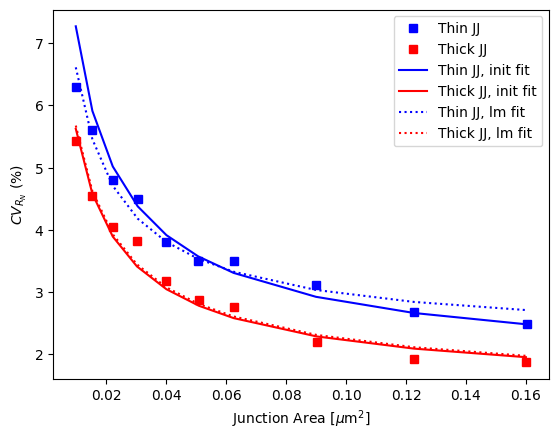

In [ ]:
#calculation for thick and thin oxides.

A_thick_JJ = np.array([0.00983, 0.01537, 0.02217, 0.03024, 0.04006, 0.0509, 0.06249, 0.0902, 0.12271, 0.16]) #um^{2}
A_thin_JJ = np.array([0.00983, 0.01537, 0.02217, 0.03049, 0.04006, 0.05065, 0.06249, 0.08995, 0.12271, 0.16025]) #um^{2}
CV_RN_thick = np.array([5.42799, 4.53955, 4.04057, 3.80933, 3.17647, 2.87221, 2.75051, 2.19067, 1.91075, 1.86207]) #percent
CV_RN_thin = np.array([6.29209, 5.59838, 4.79513, 4.49087, 3.79716, 3.4929, 3.4929, 3.10345, 2.67748, 2.48276]) #percent

#fitting program -guess best fit by eye:
#Ref 5: sigma_d_thin = 4 nm = 0.004 um, cv_rj_thin=1.8%
fit_thin = fit_CV_RN(A_arr=A_thin_JJ, cv_rj=1.75, sigma_d=(0.0035))  #big-issue different from expectation
#Ref 5: sigma_d_thick = 2.7 nm = 0.004 um, cv_rj_thin=1.4%
fit_thick = fit_CV_RN(A_arr=A_thick_JJ, cv_rj=1.4, sigma_d=(0.0027))  #big difference from osman result

#lmfit program
fit_lm_thin, fit_lm_thin_params = lm_CV_RN(xdata=A_thin_JJ, ydata=CV_RN_thin, show=['N', 'N'])
fit_lm_thick, fit_lm_thick_params = lm_CV_RN(xdata=A_thick_JJ, ydata=CV_RN_thick, show=['N', 'N'])

#results of lmfit
cv_rj_thin = ufloat(fit_lm_thin_params['cv_rj'][0], fit_lm_thin_params['cv_rj'][1])
sigma_d_thin = ufloat(fit_lm_thin_params['sigma_d'][0], fit_lm_thin_params['sigma_d'][1])
cv_rj_thick = ufloat(fit_lm_thick_params['cv_rj'][0], fit_lm_thick_params['cv_rj'][1])
sigma_d_thick = ufloat(fit_lm_thick_params['sigma_d'][0], fit_lm_thick_params['sigma_d'][1])

print('LMFIT Report')
print('CV_rj thin JJs = {:.1f} +/- {:.1f} percent'.format(cv_rj_thin.n, cv_rj_thin.std_dev))
print('sigma_d thin JJs = {:.1f} +/- {:.1f} nm'.format(sigma_d_thin.n*1E3, sigma_d_thin.std_dev*1E3))
print('CV_rj thick JJs = {:.1f} +/- {:.1f} percent'.format(cv_rj_thick.n, cv_rj_thick.std_dev))
print('sigma_d thick JJs = {:.1f} +/- {:.1f} nm'.format(sigma_d_thick.n*1E3, sigma_d_thick.std_dev*1E3))
print('\n')
print('Ref 5 Report')
print('CV_rj thin JJs = {:.1f} percent'.format(1.8))
print('sigma_d thin JJs = {:.1f} nm'.format(4.0))
print('CV_rj thick JJs = {:.1f} percent'.format(1.4))
print('sigma_d thick JJs = {:.1f} nm'.format(2.7))

#plot data
plt.plot(A_thin_JJ, CV_RN_thin, 'bs', label='Thin JJ')
plt.plot(A_thick_JJ, CV_RN_thick, 'rs', label='Thick JJ')
#plot fit
plt.plot(A_thin_JJ, fit_thin, 'b-', label='Thin JJ, init fit')
plt.plot(A_thick_JJ, fit_thick, 'r-', label='Thick JJ, init fit')
#plot lmfit
plt.plot(A_thin_JJ, fit_lm_thin, 'b:', label='Thin JJ, lm fit')
plt.plot(A_thick_JJ, fit_lm_thick, 'r:', label='Thick JJ, lm fit')

plt.xlabel(r'Junction Area [$\mu$m$^{2}$]')
plt.ylabel(r'$CV_{R_N}$ (%)')
plt.legend(loc='best')
plt.show()

Plotting the guess "A", "CV_Rj" and "CV_RN" based on varying junction areas

3.5744243177605584e-05
0.0005759564133404936


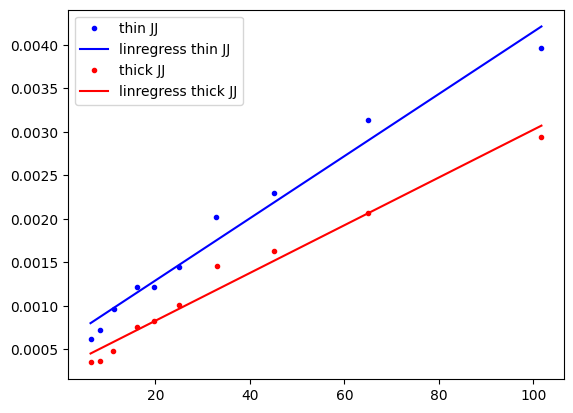

In [ ]:
slope_thin, int_thin = linregress(x=1/A_thin_JJ,y=(CV_RN_thin/100)**2)[:2]
slope_thick, int_thick = linregress(x=1/A_thick_JJ,y=(CV_RN_thick/100)**2)[:2]
print(slope_thin)
print(int_thin)
line_thin = slope_thin/A_thin_JJ + int_thin
line_thick = slope_thick/A_thick_JJ + int_thick

plt.plot(1/A_thin_JJ, (CV_RN_thin/100)**2, 'b.', label='thin JJ')
plt.plot(1/A_thin_JJ, line_thin, 'b-', label='linregress thin JJ')
plt.plot(1/A_thick_JJ, (CV_RN_thick/100)**2, 'r.', label='thick JJ')
plt.plot(1/A_thick_JJ, line_thick, 'r-', label='linregress thick JJ')
plt.legend(loc='best')
plt.show()

In [ ]:
m = guess_CV_RN(xdata=A_thick_JJ, ydata=CV_RN_thick)


Parameters([('a', <Parameter 'a', value=5823635.660463898, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=17580.84761336177, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=0.32130141002557727, bounds=[-inf:inf]>)])


#Added depth to Osman's Previous and Current Submitted work

While Refs. [5,6] made the coefficient of variation noting the uniformity of the barrier $CV_{Rj}$ as its own variable in an empirical fitting model, we attempt to give phenomenological description of this dependence as it is not clear in the Barattoff relation how $R_{j}$ varies with the gap thickness.

Replacing $R_{N}$ with the previous expression, the simplified Ambegaokar-Relation directs to the critical current density $$R_{J} = \frac{\pi \Delta A}{2eI_{c}} = \frac{\pi \Delta}{2eJ_{c}}.$$

A simplified dependence between the critical current density $J_{c}$ with the barrier thickness $h_{ox}$ can be written as noted in [7],

$$J_{c}=\frac{e \hbar n_{cp}}{2m_{cp}\xi}\frac{1}{\rm{sinh}(h_{ox}/\xi)} = \frac{e \hbar B_{cp}}{2\xi}\rm{csch}(h_{ox}/\xi)$$

where $n_{cp}$ is the number of cooper-pairs, $m_{cp}$ is the mass of the cooper-pairs and $\xi$ is the decay length defined in BCS theory as
$$ \xi=\sqrt{\frac{\hbar^{2}}{2m_{cp}(V_{0}-E_{F})}}$$
where $V_{0}$ is the barrier height and $E_{F}$ is the Fermi energy of the superconductor. Note that $B_{cp}=n_{cp}/m_{cp}$ represents cooper-pair-related terms.

##Case 1: $h_{ox} \rightarrow \xi$

Given that $h_{ox} \rightarrow \xi$, the critical current density is expressed with an exponential decay approxiamation [8]

$$J_{c}=\frac{e \hbar n_{cp}}{m_{cp}\xi} \rm{exp}\left(-\frac{h_{ox}}{\xi} \right) = \frac{e \hbar B_{cp}}{\xi} \rm{exp}\left(-\frac{h_{ox}}{\xi} \right).$$

According to [7], even with atomic layer deposition steps, wide variations of $J_{c}$ were recorded which goes beyond the scaling of $h_{ox}$ which implies that the $\eta$ varies per fabrication cycle and batch. This can be attributed to contamination and non-uniformity in the barrier interface, which can suppress $J_{c}$.

Assuming that the $\Delta$ is constant for an $Al/AlO_{x}/Al$ junction (or even a hybrid Nb-Al-AlOx-Al-Nb), we can relate $R_{j}$ with the barrier thickness.
 $$R_{j} = \frac{\pi \Delta}{2e} \frac{\xi}{e \hbar B_{cp}} \rm{exp}\left(\frac{h_{ox}}{\xi} \right) = \frac{\pi \Delta \xi}{2e^{2}\hbar B_{cp}} \rm{exp}\left(\frac{h_{ox}}{\xi} \right)$$
We then get its standard deviation $\sigma_{Rj}=dR_{j}$ through $dh_{ox}=\sigma_{h}$
$$\sigma_{Rj}=\frac{\pi \Delta}{2e^{2}\hbar B_{cp}} \rm{exp}\left(\frac{h_{ox}}{\xi} \right) \sigma_{h_{ox}}$$
Alas! The coefficient of variation related to the critical current density, which is not covered by Osman and colleagues [5], has a simplified relation related to the coherence length of the junction in the limit of thick $h_{ox}$...

$$CV_{Rj}=\frac{\sigma_{Rj}}{R_{j}}=\frac{\sigma_{h_{ox}}}{\xi}$$

##Case 2: $h_{ox} \ll \xi$
We are interested in the full picture of the dependence by considering the hyperbolic functions for moderate cases of $h_{ox}$. The resistance parameter can then be expressed with a hyperbolic function dependence with $h_{ox}$

 $$R_{j} = \frac{\pi \Delta}{2e} \frac{2\xi}{e \hbar B_{cp}} \rm{sinh}\left(\frac{h_{ox}}{\xi} \right) = \frac{\pi \Delta \xi}{e^{2}\hbar B_{cp}} \rm{sinh}\left(\frac{h_{ox}}{\xi} \right),$$

 and the standard deviation is defined as

  $$\sigma_{Rj} = \frac{\pi \Delta }{e^{2}\hbar B_{cp}} \rm{cosh}\left(\frac{h_{ox}}{\xi} \right) \sigma_{h_{ox}}.$$

The generalized coefficient of variation related to junction frequency is expressed as $T=0$ is
$$CV_{Rj}=\frac{\sigma_{Rj}}{R_{j}}=\frac{\sigma_{h_{ox}}}{\xi} \rm{coth}\left(\frac{h_{ox}}{\xi}
   \right)$$

The model tells us that thinner barrier causes significant variations and at
increasing oxide thicknesses, the variation saturates at the uniformity of the oxide and the coherence length. The behavior is consistent with the recent results with Osman and colleagues [4,5]. However, be wary that thick oxides can cause TLS frequencies to resonate within the qubit operation [5].

A limit of this analysis though does not take to account the relationship between the superconducting gap $\Delta$ and $h$ which has some indirect mapping based on old and recent reports of gap engineering by thickness [9]. It would be useful to also include this $\Delta=\Delta(h_{b})$ in future analysis. However, for now, I believe this $\Delta$ is not a limiting factor, but is related to uniformity issues.


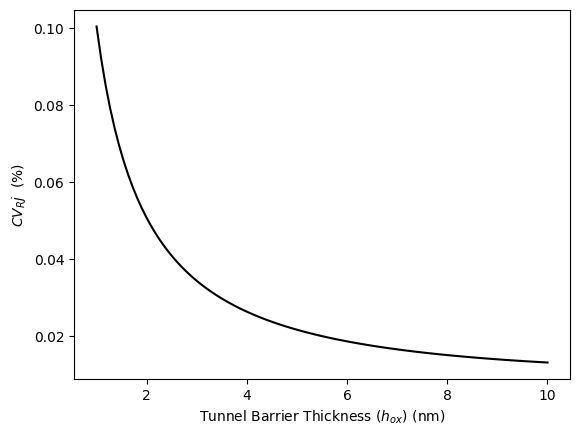

In [ ]:
#calculation for thickness dependent of barrier on superconducting gap
xi_Al = 10 #nm
h_ox = 1 #nm
sigma_h = 0.001 #nm

h_ox_arr = np.linspace(1, 10, 101) #varied from 1 - 10 nm thicknesses

CV_Rj_x = np.array([CV_Rj(h_ox_arr[i], sigma_h, xi_Al) for i in range(len(h_ox_arr))])

plt.plot(h_ox_arr, CV_Rj_x, 'k-')
plt.xlabel(r'Tunnel Barrier Thickness ($h_{ox}$) (nm)')
plt.ylabel(r'$CV_Rj$  (%)')
plt.show()

The coth function is quite high below 1 nm. The ratio $\sigma_h/\xi$ gives the lower limit at $h\rightarrow \eta$. But this $\sigma_h$ dominates in decreasing the $CV_{Rj}$.


## A full picture of the coefficient of variation for resistance variations with SIS josephson junctions.

Using the previous model made by Osman, we then define the phenomenology behind the coefficient of resistance variations, which can be fitted with polynomial functions when using dependence of junction area and barrier heights.
$$(CV_{RN})^{2} = \left[\left(\frac{\sigma_{h_{ox}}}{\xi} \rm{coth}\left(\frac{h_{ox}}{\xi}
   \right) \right)^{2}+1 \right]\left( \frac{4\sigma_{d}^{2}}{A}\ \right) + \left(\frac{\sigma_{h_{ox}}}{\xi} \rm{coth}\left(\frac{h_{ox}}{\xi}
   \right) \right)^{2}.$$
At $h_{ox} \leftarrow \xi$ in a way that we still maintain the superconducting phase of the qubit, the coefficient of variation is still related to the qubit.
$$(CV_{RN})^{2} = \left[\left(\frac{\sigma_{h_{ox}}}{\xi} \right)^{2}+1 \right]\left( \frac{4\sigma_{d}^{2}}{A}\ \right) + \left(\frac{\sigma_{h_{ox}}}{\xi}  \right)^{2}.$$

What the latter work in Osman and Delsing had done is fit this parameter in this quantity and then latter express the quantity as the square-root of the fitting and the experiment, as a function of the junction area $A$. From the coefficients of $A$ and the other polynomial constants, one can get the $CV_{RJ}$ and $\sigma_{d}$. Furthermore our derivation enable us to test this idea with thickness variation which will take multiple fabrication and cooldown cycles, and which step the group will have difficulty of performing. The presence of some coherence length $\xi$ is telling that high coherence length materials like aluminum or tantalum can further reduce the effects of thickness non-uniformity, allowing as to project that the biggest limiting factor for resistance variation lies with $\sigma_{d}$ related to line roughness.

#Establishing frequency variation with resistance variation

We test the assertion of Hertzberg et al. of IBM that $$\frac{\sigma_{f}}{\left< f \right> } = \frac{\sigma_{R}}{2 \left< R_{N}\right>}$$.
As we have known the transmon frequency earlier, we express the transmon frequency as a function of $R_{N}$ based on the simplified Ambegaokar-Baratoff relation. Recall that $E_{J}=\frac{\Phi_0 I_{c}}{2 \pi}$, and $I_{c} = \frac{\pi \Delta}{2e R_{N}}$. Then, $E_{J} = \frac{\Phi_0 \Delta}{4eR_{N}}$. Then, in terms of the mean normal state resistance $R_{N}$, the fundamental transition frequency of the transmon is $$f_{01} = \frac{\sqrt{\frac{\Phi_0 \Delta}{4eR_{N}}}\sqrt{8\frac{e^{2}}{2C}} - \frac{e^{2}}{2C}}{h} = \frac{1}{h}\left[ \sqrt{\frac{e\Phi_0 \Delta}{CR_{N}}} - \frac{e^{2}}{2C} \right]$$
Getting the standard deviation requires getting the derivative
$$df_{01} = \sigma_{f} = \frac{-1}{2h} \sqrt{\frac{e\Phi_0 \Delta}{C}} \sqrt{\frac{1}{R_{N}^{3}}} \sigma_R.$$
Assuming $\left< f \right> = f_{01}$ and $\left< R \right> = R_{N}$, using D=$\sqrt{e\Phi_0\Delta/C}$ and in the regime that $E_{J}/E_{C} \gg 1$, we get the relation:
$$\frac{\sigma_{f}}{\left< f \right>} = -\frac{1}{2} \frac{D \left<R \right>^{-3/2} \sigma_{R}}{D \left< R \right>^{-1/2} + E_{C}} \rightarrow -\frac{1}{2}\frac{\sigma_{R}}{\left< R \right>}.$$

The negative sign is irrelevant in this analysis. To make the analysis fair, recent works dealing with coefficient of variations in resistances [4,5] take the square of the variance, and finally take the square-root.

# References

1. Create optimizer for Empirical Probability Density Distribution Function introduced by  https://stackabuse.com/kernel-density-estimation-in-python-using-scikit-learn/
2. https://scqubits.readthedocs.io/en/v3.3/guide/circuit/ipynb/custom_circuit_define_more.html
3. Martinis, John. (2004) Superconducting Qubits and the Physics of Josephson Junctions. Les Houches Session LXXIX (2003): Quantum Entanglement and Information Processing, 487-520 (2004). arxiv:cond-mat/0402415
4. Osman, A., Simon, J., Bengtsson, A., Kosen, S., Krantz, P., P. Lozano, D., . . . Fadavi Roudsari, A. (2021). Simplified Josephson-junction fabrication process for reproducibly high-performance superconducting qubits. Applied Physics Letters, 118(6). doi:10.1063/5.0037093
5. Osman, A., Fernández-Pendás, J., Warren, C., Kosen, S., Scigliuzzo, M., Frisk Kockum, A., . . . Bylander, J. (2023). Mitigation of frequency collisions in superconducting quantum processors. Physical Review Research, 5(4). doi:10.1103/PhysRevResearch.5.043001
6. Tolpygo and Oliver et al., IEEE Trans. Appl. Supercond., vol. 25, No. 3, p.1101312, June 2015
7. Elliot, A. J. (2014). Josephson Junctions with Tunnel Barriers Grown via In Situ Atomic Layer Deposition. (PhD PhD Thesis), University of Kansas, Kansas, Arkansas.
8. Orlando, Terry P. and Delin, Kevin A. (1991). Foundations of Applied Superconductivity (1st Ed, Addison-Wesley, New York).
9. Suppression of quasiparticle poisoning in transmon qubits by gap engineering. https://arxiv.org/abs/2309.02655
